# 多変量LSTM: 出力の可視化

### 機能
- 入力: 50日分の値
- 出力: 50日分の予測

### 結果と問題点
- 形を模倣できているものもある
- 変化率が総じて緩やか
- 予測位置がまるごと上か下にずれている

### 原因？
- 入力データの準備の仕方が悪そう？(一つずつずらしている)
- 訓練ロスとかを見ても明らかにepochが足りないし、学習が足りていなさそう(？)
- そもそも学習できていない？

In [1]:
import sys
import inspect
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation

import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torch.optim as optim

from mv_lstm_preprocess import mv_dataset
from mv_lstm_model import mv_lstm, mv_lstm_same_seq

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(1)
print(device)

cpu


In [7]:
seq_len = 50
predict_len = seq_len
predict_features = [0,1]
batch_size = 50
dropout = 0.2

epochs_num = 50
eps = 0.01
hidden_size = 20
num_layers = 2
input_size = None # 後から
output_size = len(predict_features)

In [8]:
file_paths = ["data/market_data_rm_inflation.csv", "data/nikkei_data.csv", "data/jgbcm_9.csv"]
dataset = mv_dataset(file_paths, seq_len=seq_len, predict_len=predict_len, predict_data=predict_features)

In [9]:
input_size = dataset.dfs.shape[1]

model = mv_lstm_same_seq(input_size, 
                            output_size,
                            hidden_size=hidden_size, 
                            num_layers = num_layers, 
                            batch_size = batch_size, 
                            seq_len = seq_len, 
                            predict_len = predict_len,
                            dropout = 0.2)
model.load_state_dict(torch.load("mv_lstm_same_seq.pth"))
model.eval()

mv_lstm_same_seq(
  (lstm): LSTM(4, 20, num_layers=2, batch_first=True, dropout=0.2)
  (linear): Linear(in_features=20, out_features=2, bias=True)
)

In [38]:
model_name = "mv_lstm_same_seq"
using_data = "_data_usgd_ussp_nikkei_jgbcm"
condition = model_name + using_data + "_with_seq" + str(seq_len) + "_pred" + str(predict_len) +  "_ep" + str(epochs_num) + "_batch" + str(batch_size)+ "_hs" + str(hidden_size) + "_eps" + str(eps)
print(condition)

mv_lstm_same_seq_data_usgd_ussp_nikkei_jgbcm_with_seq50_pred50_ep50_batch50_hs20_eps0.01


In [11]:
def predict(dataset, model, pos, seq_len, predict_len, fig_name=None):
    plt.clf()
    seq, label = dataset[pos]
    seq_lines, label_lines = seq.transpose(0,1), label.transpose(0,1)
    seq_range, predict_range = range(-seq_len + 1, 1), range(1, predict_len + 1)
    
    for i, seq_line in enumerate(seq_lines):
        plt.plot(seq_range, seq_line, marker='o', label="base sequence" + str(i))
        
    for i, label_line in enumerate(label_lines):
        plt.plot(predict_range, label_line, marker='o', label="expected sequence" + str(i))
        
    predicted_lines = model(seq.view(1, seq.shape[0], seq.shape[1])).detach().numpy()[0].T
    for i, predicted_line in enumerate(predicted_lines):
        plt.plot(predict_range, predicted_line, marker='x', label="predicted sequence" + str(i))
        
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("predict all lines from " + dataset.dfs.index[pos+seq_len] + " (index: " + str(pos) + ")")
    plt.show() if fig_name is None else plt.savefig(fig_name + "_predict_all_from" + dataset.dfs.index[pos+seq_len] + " (index: " + str(pos) + ")" + ".png")

In [12]:
def predict_usgb(dataset, model, pos, seq_len, predict_len, fig_name=None):
    plt.clf()
    seq, label = dataset[pos]
    seq_lines, label_lines = seq.transpose(0,1), label.transpose(0,1)
    seq_range, predict_range = range(-seq_len + 1, 1), range(1, predict_len + 1)
    plt.plot(seq_range, seq_lines[0], marker='o', label="base sequence")
    plt.plot(predict_range, label_lines[0], marker='o', label="expected sequence")
        
    predicted_lines = model(seq.view(1, seq.shape[0], seq.shape[1])).detach().numpy()[0].T
    plt.plot(predict_range, predicted_lines[0], marker='x', label="predicted sequence")
        
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("predict usgb10 from " + dataset.dfs.index[pos+seq_len] + " (index: " + str(pos) + ")")
    plt.show() if fig_name is None else plt.savefig(fig_name + "_predict_usgb_from" + dataset.dfs.index[pos+seq_len] + " (index: " + str(pos) + ")" + ".png")

In [18]:
def predict_ussp(dataset, model, pos, seq_len, predict_len, fig_name=None):
    plt.clf()
    seq, label = dataset[pos]
    seq_lines, label_lines = seq.transpose(0,1), label.transpose(0,1)
    seq_range, predict_range = range(-seq_len + 1, 1), range(1, predict_len + 1)
    plt.plot(seq_range, seq_lines[1], marker='o', label="base sequence")
    plt.plot(predict_range, label_lines[1], marker='o', label="expected sequence")

    predicted_lines = model(seq.view(1, seq.shape[0], seq.shape[1])).detach().numpy()[0].T
    plt.plot(predict_range, predicted_lines[1], marker='x', label="predicted sequence")

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("predict ussp500 from " + dataset.dfs.index[pos+seq_len] + " (index: " + str(pos) + ")")
    plt.show() if fig_name is None else plt.savefig(fig_name + "_predict_ussp_from" + dataset.dfs.index[pos+seq_len] + " (index: " + str(pos) + ")" + ".png")

In [33]:
pos = 10000

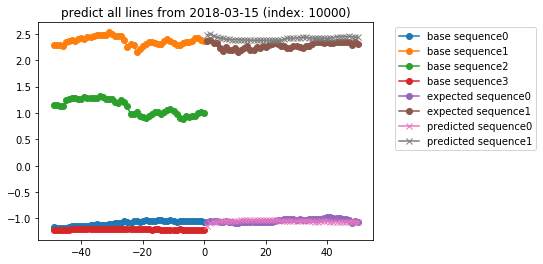

In [39]:
# predict(dataset, model, pos, seq_len, predict_len)
predict(dataset, model, pos, seq_len, predict_len, condition)

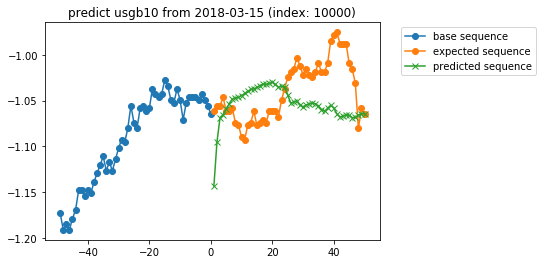

In [40]:
# predict_usgb(dataset, model, pos, seq_len, predict_len)
predict_usgb(dataset, model, pos, seq_len, predict_len, condition)

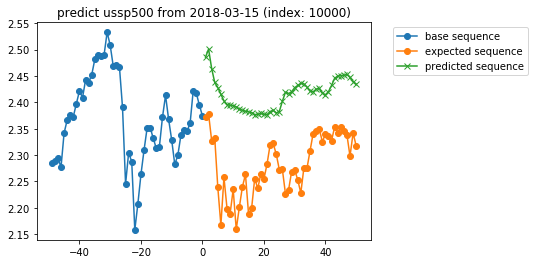

In [41]:
# predict_ussp(dataset, model, pos, seq_len, predict_len)
predict_ussp(dataset, model, pos, seq_len, predict_len, condition)

In [44]:
import subprocess
subprocess.run(['jupyter', 'nbconvert', '--to', 'python', 'mv_lstm_predict.ipynb'])

CompletedProcess(args=['jupyter', 'nbconvert', '--to', 'python', 'mv_lstm_predict.ipynb'], returncode=0)